In [1]:
# preprocessing
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.neighbors import KNeighborsClassifier
from utils import create_image_table, create_image, upscale

# load data
matfile = loadmat('face.mat')
data = matfile['X']

# create labels, there are 10 images of each face
labels = []
for i in range(52):
    labels.extend([i] * 10)
labels = np.array(labels)

# train and test set
d, N = data.shape
train_idx = []
test_idx = []
for i in range(N//10):
    s = i * 10
    train_idx.extend(list(range(s, s+8)))
    test_idx.extend(list(range(s+8, s+10)))
X_train = np.take(data, train_idx, axis=1)
X_test = np.take(data, test_idx, axis=1)
y_train = np.take(labels, train_idx, axis=0)
y_test = np.take(labels, test_idx, axis=0)


# split train set into 4 sets of 104 images
# need to 2 images of each class in each split
X_sets, y_sets = [], []
for i in range(4):
    X_sets.append(X_train[:, i::4])
    y_sets.append(y_train[i::4])

In [2]:
N_COMPONENTS = 100

def incremental_pca(X):
    inc_pca = IncrementalPCA(batch_size=104, n_components=N_COMPONENTS)
    inc_pca.fit(X.T);
    return inc_pca

def full_pca(X):
    pca = PCA(n_components=N_COMPONENTS)
    pca.fit(X.T);
    return pca

# NN classification
def predict(pca, X_train, y_train):
    """Perform NN-classification on training data, with a fitted sklearn-pca object"""
    # test and training data is (d, N) matrix
    d, N = X_train.shape
    train_subspace = pca.transform(X_train.T)
    test_subspace = pca.transform(X_test.T)
    # only take first nearest neighbour
    neigh = KNeighborsClassifier(n_neighbors=1, algorithm='brute')
    neigh.fit(train_subspace, y_train)
    predictions = neigh.predict(test_subspace)
    return predictions

def accuracy(prediction):
    return np.count_nonzero(prediction==y_test) / len(y_test)

def reconstruct(pca, sample):
    sample = sample.reshape(-1, 1)
    downsampled = pca.transform(sample.T)
    upsampled = pca.inverse_transform(downsampled)
    return upsampled.T



Calculate performance estimates of all the different PCA versions.
Take 5 measurements and take their mean.

In [60]:
mean_times = [0] * 5

In [62]:
%%time
# full PCA
full_pca(X_train)
results = [2.29, 4.01, 3.91, 3.56, 3.16]
mean_times[0] = np.mean(results)

CPU times: user 2.31 s, sys: 1.4 s, total: 3.71 s
Wall time: 1.39 s


In [63]:
%%time
# just first batch
full_pca(X_sets[0])
results = [0.238, 0.183, 0.443, 0.223, 0.601]
mean_times[1] = np.mean(results)

CPU times: user 234 ms, sys: 89 ms, total: 323 ms
Wall time: 147 ms


In [69]:
%%time
# first 2 sets
incremental_pca(np.concatenate(X_sets[:2], axis=1))
results = [1.69, 2.84, 2.33, 2.61, 2.87]
mean_times[2] = np.mean(results)

CPU times: user 2.16 s, sys: 1.77 s, total: 3.93 s
Wall time: 2.09 s


In [75]:
%%time
# 3 sets
incremental_pca(np.concatenate(X_sets[:3], axis=1))
results = [2.83, 4.62, 5.53, 5.4, 4.03]
mean_times[3] = np.mean(results)

CPU times: user 3.12 s, sys: 2.73 s, total: 5.85 s
Wall time: 3.37 s


In [83]:
%%time
# all 4 sets
incremental_pca(np.concatenate(X_sets, axis=1))
results = [5.98, 5.41, 5.65, 5.52, 4.45]
mean_times[4] = np.mean(results)

CPU times: user 2.9 s, sys: 2.08 s, total: 4.98 s
Wall time: 2.7 s


In [88]:
mean_times = [round(t, 3) for t in mean_times]
print(mean_times)

[3.386, 0.338, 2.468, 4.482, 5.402]


In [105]:
def do_inc_pca(sets: int):
    assert sets in [1,2,3,4]
    X_vals = np.concatenate(X_sets[:sets], axis=1)
    y_vals = np.concatenate(y_sets[:sets], axis=0)
    inc_pca = incremental_pca(X_vals)
    preds = predict(inc_pca, X_vals, y_vals)
    acc = accuracy(preds)
    print(f'{acc=:.4f}')
    return inc_pca

do_inc_pca(4);

acc=0.6731


Construc

acc=0.2212
acc=0.3173
acc=0.5192
acc=0.6635


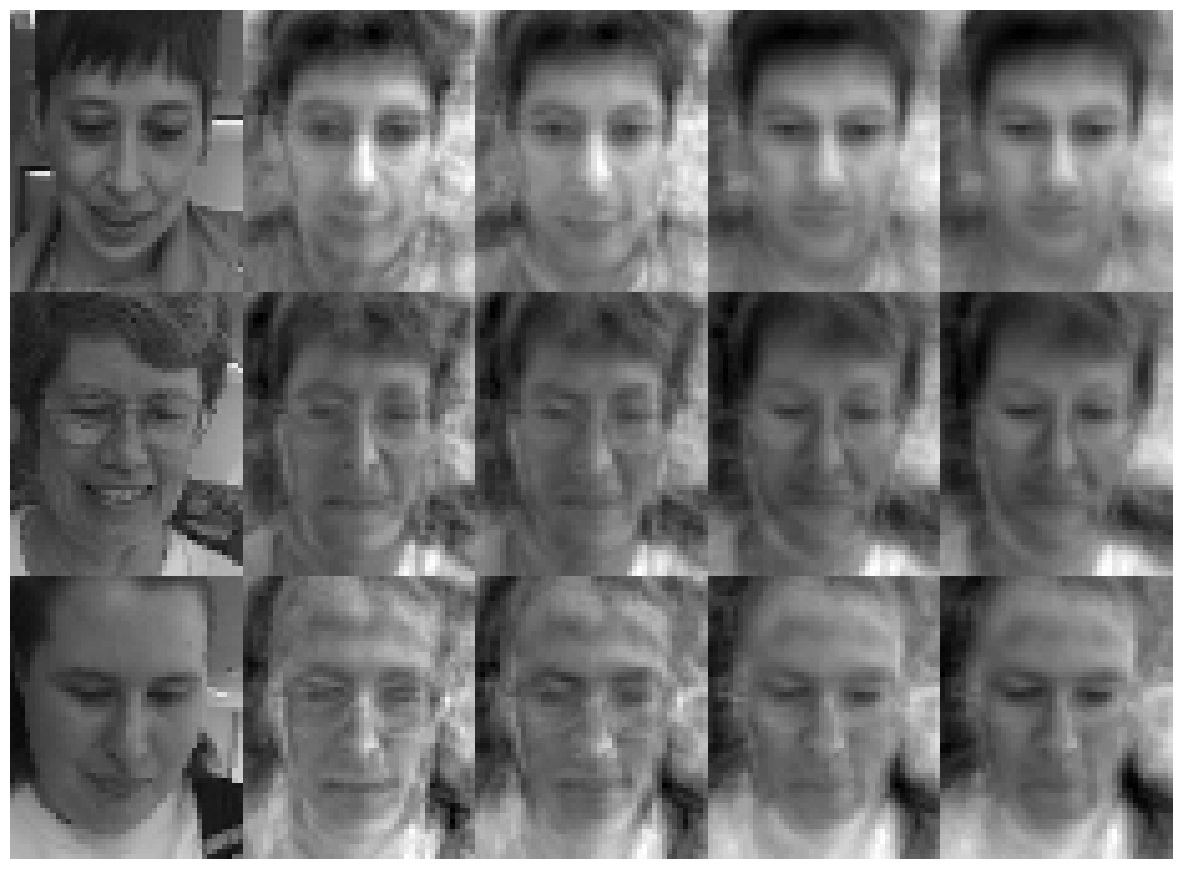

In [128]:
# construct image showing reconstruction error of 3 different training
# samples
sample1 = np.reshape(X_test[:, 20], (-1,1))
sample2 = np.reshape(X_test[:, 22], (-1,1))
sample3 = np.reshape(X_test[:, 24], (-1,1))
for i in range(1, 5):
    ipca = do_inc_pca(i)
    rec1 = upscale(reconstruct(ipca, sample1[:, 0]))
    rec2 = upscale(reconstruct(ipca, sample2[:, 0]))
    rec3 = upscale(reconstruct(ipca, sample3[:, 0]))
    sample1 = np.concatenate([sample1, rec1], axis=1)
    sample2 = np.concatenate([sample2, rec2], axis=1)
    sample3 = np.concatenate([sample3, rec3], axis=1)

all_imgs = np.concatenate([sample1, sample2, sample3], axis=1)
create_image_table(all_imgs, 5, savename='ipca_reconstruction.png')

ValueError: Unrecognized marker style '--'

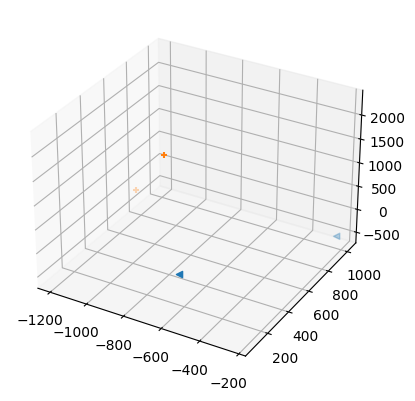

In [102]:
vis_pca = PCA(n_components=3)
vis_pca.fit(X_train.T)
s_test = vis_pca.transform(X_sets[0][:, :8].T)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(s_test[:2, 0], s_test[:2, 1], s_test[:2, 2], marker='<')
ax.scatter(s_test[2:4, 0], s_test[2:4, 1], s_test[2:4, 2], marker='+')
ax.scatter(s_test[4:6, 0], s_test[4:6, 1], s_test[4:6, 2], marker='--')
ax.scatter(s_test[6:8, 0], s_test[6:8, 1], s_test[6:8, 2], marker='.')

ax.legend=True
